# Contrastive Learning

This example demonstrates how to implement a Contrastive Learning Siamese Network using Contrastive Loss to determine whether a pair of images are similar. Contrastive Loss was introduced by Yann Le Cunn et al. in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf).

<img src='../siamese-network.png' alt='Siamese Network' width="1000">


In [38]:
# Run in Jupyter cell
import tensorflow as tf
import keras
import sys
import platform

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:", sys.version)
print("Platform:", platform.platform())

# Check Metal support
print("\nMetal devices:", tf.config.list_physical_devices('METAL'))

TensorFlow version: 2.12.0
Keras version: 2.12.0
Python version: 3.10.15 (main, Sep  7 2024, 00:20:06) [Clang 15.0.0 (clang-1500.3.9.4)]
Platform: macOS-14.7.1-x86_64-i386-64bit

Metal devices: []


In [39]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

Let's start by loading the dataset:


In [40]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Let's now display some of the images with their labels:


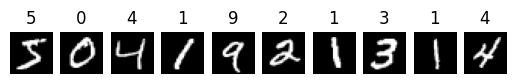

In [41]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

We want to create a neural network that receives every pixel as an input. Let's reshape the data to have a single array with `28 x 28 = 784` pixels.


In [42]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


We now want to normalize the pixel values to a range between 0 and 1 (instead of 0 to 255). We can use the min-max normalization formula for this:

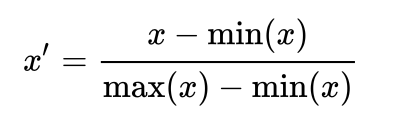

Here is what the code to implement this formula would look like:

```
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
```

For an image, `X_train.min()` is `0` and `X_train.max()` is `255`, so we can simplify the formula to:

```
X_train = X_train / 255.0
```


In [43]:
X_train = X_train / 255.0
X_test = X_test / 255.0

We'll train a Siamese Network using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while a negative pair consists of two images representing different digits.


In [44]:
import numpy as np


def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

Let's generate the pairs for training and testing the model:


In [45]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


Let's display some of these pairs to ensure they were generated correctly:


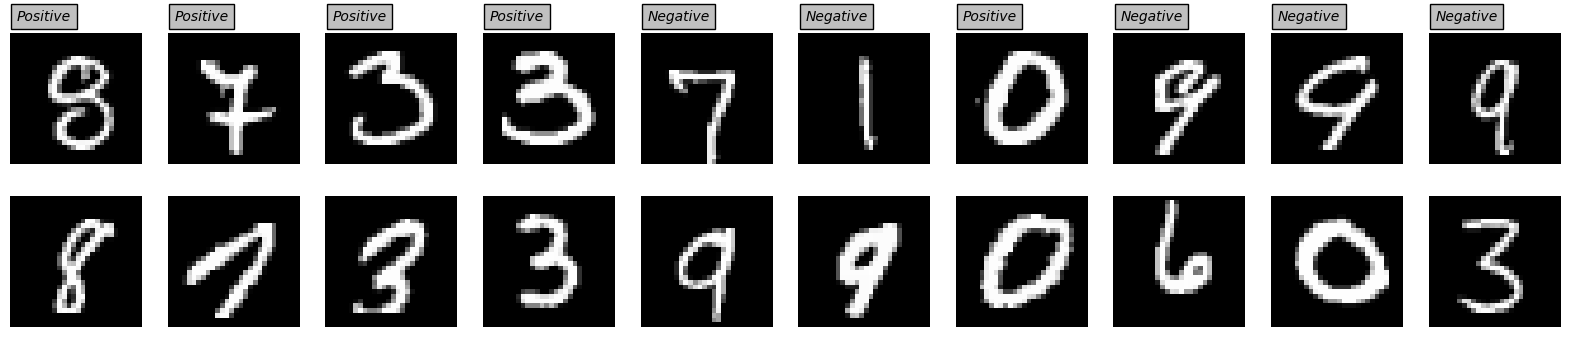

In [46]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

It's time to start building the Siamese Network. Let's first define the inputs that will receive the pair of images:


In [47]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

Then, we can build the body of the Siamese Network. This network will be responsible of generating the embeddings for each of the input images:


In [48]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation=None),
    ]
)

Our network will have two branches, each one responsible for processing one of the images in the pair. We want to share the same weights between the branches, so we'll use the same network instance:


In [49]:
twin1 = network(input1)
twin2 = network(input2)

The output of the Siamese Network will be the distance between the embeddings of the two images. To do this, we can use a Lambda layer to calculate the Euclidean distance between the embeddings:


In [50]:
from keras.layers import Lambda
import tensorflow as tf

def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return tf.norm(twin1_output - twin2_output, axis=1, keepdims=True)

distance = Lambda(euclidean_distance)([twin1, twin2])

Let's now set up the model:


In [51]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the Contrastive Loss to train the model. You can find the formula of this loss in the paper ["Dimensionality Reduction by Learning an Invariant Mapping."](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)


In [52]:
import tensorflow as tf

def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """
    margin = 1
    y = tf.cast(y, d.dtype)
    
    # Square of distances
    square_d = tf.square(d)
    
    # Square of margin difference
    square_margin_diff = tf.square(tf.maximum(0.0, margin - d))
    
    # Compute loss
    loss = (1 - y) / 2 * square_d + y / 2 * square_margin_diff
    
    return loss

Let's compile the model using the Contrastive Loss:


In [53]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

Here is what the model architecture looks like:


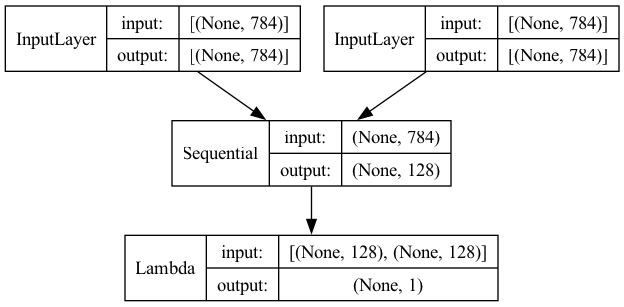

In [54]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

Let's fit the model:


In [55]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5


2024-11-12 06:09:07.310097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - ETA: 0s - loss: 0.0291 - binary_accuracy: 0.9440

2024-11-12 06:10:54.607276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3750/3750 [==============================] - 114s 30ms/step - loss: 0.0291 - binary_accuracy: 0.9440 - val_loss: 0.0187 - val_binary_accuracy: 0.9673
Epoch 2/5
3750/3750 [==============================] - 113s 30ms/step - loss: 0.0132 - binary_accuracy: 0.9807 - val_loss: 0.0146 - val_binary_accuracy: 0.9718
Epoch 3/5
3750/3750 [==============================] - 113s 30ms/step - loss: 0.0096 - binary_accuracy: 0.9871 - val_loss: 0.0146 - val_binary_accuracy: 0.9708
Epoch 4/5
3750/3750 [==============================] - 113s 30ms/step - loss: 0.0077 - binary_accuracy: 0.9904 - val_loss: 0.0134 - val_binary_accuracy: 0.9714
Epoch 5/5
3750/3750 [==============================] - 113s 30ms/step - loss: 0.0063 - binary_accuracy: 0.9925 - val_loss: 0.0130 - val_binary_accuracy: 0.9723


We can plot the train and validation loss during training:


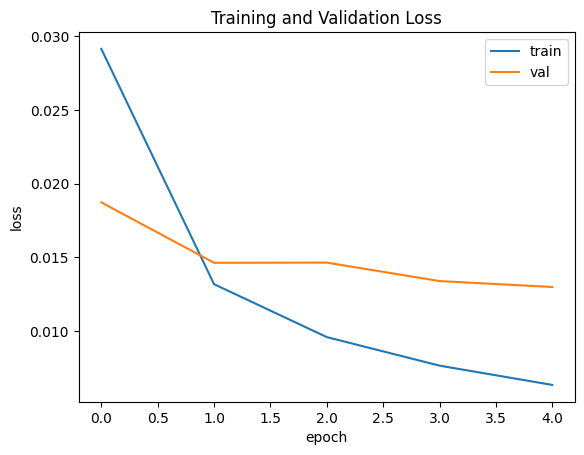

In [56]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

Let's evaluate the model using the test data and display some of the predictions:


  7/625 [..............................] - ETA: 5s  

2024-11-12 06:24:16.798254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 6s 9ms/step


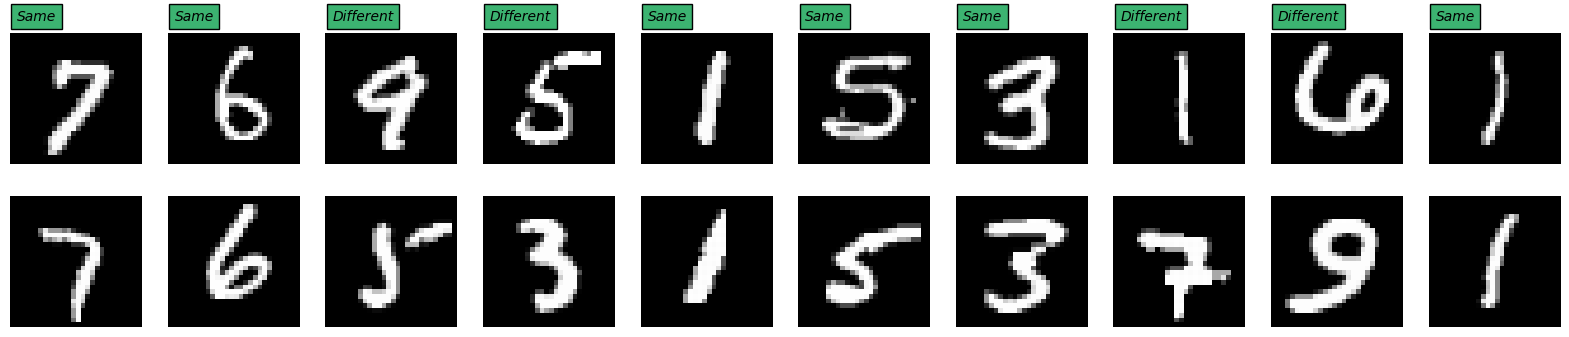

In [57]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_pairs(X_test_pairs, predictions, predictions == y_test_pairs)

Finally, we can compute the accuracy of the model on the test data:


In [58]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


These are the different layers of the model we trained:


In [59]:
model.layers

We can reference the sequential model to generate embeddings for new images:


In [60]:
embedding_model = model.layers[2]

Let's select two random images representing the digit `3`, and one image representing the digit `7`:


In [61]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(8864, 4509, 1919)

We can generate the embeddings for these 3 images:


In [62]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 [==============================] - 0s 24ms/step


2024-11-12 06:24:49.136164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The distance between the embeddings of the two images representing the digit `3` should be really small (close to 0):


In [63]:
import tensorflow as tf

tf.norm(embedding1 - embedding2).numpy()
# norm(embedding1 - embedding2).numpy()

0.011121002

The distances between the embeddings of the images representing the digit `3` and the image representing the digit `7` should be large (close to 1):


In [64]:
tf.norm(embedding1 - embedding3).numpy(), tf.norm(embedding2 - embedding3).numpy()

(0.95644766, 0.96473074)